In [1643]:
import torch
from torchvision import transforms, datasets
import torch.utils.data as data
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1644]:
df = pd.read_csv("train_data.csv")

# Data processing
- y - class from 0 to 3 according to the following:
    - 0 to 100k - class 0
    - 100k to 350k - class 1
    - 350k and above - class 2
        

Features:
- YearBuilt - numeric
- Size(sqf) - numeric
- Floor - numeric
- HallwayType - one hot encoding
- HeatingType - binary encoding
- AptManageType - binary encoding
- N_Parkinglot(Ground) - numeric
- N_Parkinglot(Basement) - numeric
- TimeToBusStop - one hot encoding
- TimeToSubway - one hot encoding
- N_manager - numeric
- N_elevators - numeric
- SubwayStation - one hot encoding
- N_FacilitiesInApt - numeric
- N_FacilitiesNearBy(Total) - numeric
- N_SchoolNearBy(Total) - numeric

Train data: 4124
Train data per class: 0 - 562, 1 - 2992, 2 - 570


In [1645]:
df

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


In [1646]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # Add classes
    df['class'] = pd.cut(df['SalePrice'], bins=[-float('inf'), 100000, 350000, float('inf')], labels=[0, 1, 2])
    df = df.drop(columns=["SalePrice"])

    # Encode TimeToSubway and TimeToBus
    df['TimeToBusStop'] = df['TimeToBusStop'].replace({
        "0~5min": 2,
        "5min~10min": 1,
        "10min~15min": 0
    })

    df['TimeToSubway'] = df['TimeToSubway'].replace({
        "0-5min": 4,
        "5min~10min": 3,
        "10min~15min": 2,
        "15min~20min": 1,
        "no_bus_stop_nearby": 0

    })
    
    # One hot encoding
    for_one_hot_encoding = ['HallwayType', 'SubwayStation']
    drop_first = True
    
    df = pd.get_dummies(df, columns=for_one_hot_encoding, drop_first=drop_first)
    
    # Binary encoding
    for_binary = ['HeatingType', 'AptManageType']
    df = pd.get_dummies(df, columns=for_binary, drop_first=True)
    
    # Scale numeric to range 0 to 1
    to_be_scaled = ['TimeToBusStop', 'TimeToSubway', 'YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)', 'N_manager', 'N_elevators', 'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
    for column in to_be_scaled:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    
    return df

In [1647]:
df = preprocess_data(df)
df

/tmp/ipykernel_6304/945653226.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimeToBusStop'] = df['TimeToBusStop'].replace({
/tmp/ipykernel_6304/945653226.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimeToSubway'] = df['TimeToSubway'].replace({


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,HallwayType_terraced,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby,HeatingType_individual_heating,AptManageType_self_management
0,0.756757,0.308356,0.047619,0.155680,0.139288,0.5,0.50,0.153846,0.000000,0.444444,...,True,False,False,False,True,False,False,False,True,False
1,0.189189,0.205268,0.166667,0.112202,0.057532,1.0,0.75,0.076923,0.074074,0.222222,...,False,False,False,True,False,False,False,False,True,True
2,0.189189,0.205268,0.119048,0.112202,0.057532,1.0,0.75,0.076923,0.074074,0.222222,...,False,False,False,True,False,False,False,False,True,True
3,0.756757,0.872389,0.166667,0.349229,0.405753,1.0,1.00,0.307692,0.407407,0.444444,...,True,False,False,False,False,False,True,False,True,False
4,0.378378,0.231153,0.023810,0.199158,0.059803,0.5,0.25,0.230769,0.296296,0.222222,...,False,False,False,False,False,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,0.783784,0.814260,0.547619,0.000000,0.961393,1.0,1.00,1.000000,0.592593,1.000000,...,True,False,False,False,True,False,False,False,True,False
4120,1.000000,0.231153,0.500000,0.143058,0.302801,1.0,0.75,0.307692,0.370370,0.666667,...,True,False,False,True,False,False,False,False,True,False
4121,0.783784,0.332879,0.452381,0.000000,0.961393,1.0,1.00,1.000000,0.592593,1.000000,...,True,False,False,False,True,False,False,False,True,False
4122,0.000000,0.541326,0.000000,0.122020,0.000000,1.0,1.00,0.000000,0.148148,0.222222,...,False,False,False,False,True,False,False,False,True,True


In [1648]:
df.shape

(4124, 24)

In [1649]:
class_counts = df['class'].to_numpy()
unique, counts = np.unique(class_counts, return_counts=True)

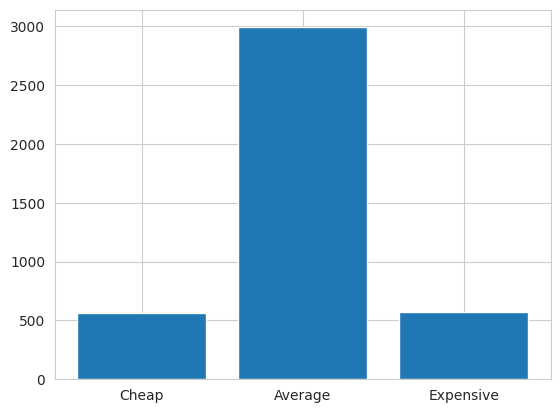

In [1650]:
plt.bar(["Cheap", "Average", "Expensive"], counts)
plt.show()

In [1651]:
class_weights = [1 / x for x in counts]
class_weights[1] *= 1.2
print(class_weights)

[np.float64(0.0017793594306049821), np.float64(0.0004010695187165775), np.float64(0.0017543859649122807)]


In [1652]:
train_dataset_raw = df.sample(frac=0.8, random_state=200)
df = df.drop(train_dataset_raw.index)
val_dataset_raw = train_dataset_raw.sample(frac=0.25, random_state=200) # 20% of original dataset
train_dataset_raw = train_dataset_raw.drop(val_dataset_raw.index)

test_dataset_raw = df
print("Dataset sizes")
print(f"Train: {len(train_dataset_raw)} samples")
print(f"Val:   {len(val_dataset_raw)} samples")
print(f"Test:  {len(test_dataset_raw)} samples")

Dataset sizes
Train: 2474 samples
Val:   825 samples
Test:  825 samples


In [1653]:
train_labels = train_dataset_raw['class'].to_numpy().astype(np.int64)
train_data = train_dataset_raw.drop(columns=['class']).to_numpy().astype(np.float32)

val_labels = val_dataset_raw['class'].to_numpy().astype(np.int64)
val_data = val_dataset_raw.drop(columns=['class']).to_numpy().astype(np.float32)

test_labels = test_dataset_raw['class'].to_numpy().astype(np.int64)
test_data = test_dataset_raw.drop(columns=['class']).to_numpy().astype(np.float32)

In [1654]:
train_dataset = data.TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = data.TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))
test_dataset = data.TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

In [1655]:
sample_weights = np.array([class_weights[label] for label in train_labels])
sample_weights = torch.FloatTensor(sample_weights)

sampler = data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [1656]:
BATCH_SIZE = 512
train_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_data_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [1657]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(device))
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

else:
    device = torch.device("cpu")

print(device.type)

NVIDIA GeForce RTX 2070 Super
cuda


In [1658]:
class ApartmentClassifier(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.layer1 = nn.Linear(num_inputs, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.act_fn1 = nn.ReLU()
        self.d1 = nn.Dropout(0.5)

        self.layer2 = nn.Linear(1024, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.act_fn2 = nn.ReLU()
        self.d2 = nn.Dropout(0.5)

        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.act_fn3 = nn.ReLU()
        self.d3 = nn.Dropout(0.4)

        self.output = nn.Linear(128, num_outputs)


    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act_fn1(x)
        x = self.d1(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act_fn2(x)
        x = self.d2(x)

        x = self.layer3(x)
        x = self.bn3(x)
        x = self.act_fn3(x)
        x = self.d3(x)

        x = self.output(x)
        return x


In [1659]:
def predict_from_logits(logits, y_hat):
    pred_probabilites = nn.Softmax(dim=1)(logits)
    predictions = pred_probabilites.argmax(1)

    correct = (predictions == y_hat).sum().item()
    return predictions, correct

In [1660]:
def train(model: nn.Module, epochs: int, optimizer, scheduler) -> np.ndarray:
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []


    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0

        train_correct = 0
        train_total = 0

        val_correct = 0
        val_total = 0

        model.train()
        for data_inputs, data_labels in train_data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            logits = model(data_inputs)

            loss = loss_module(logits.squeeze(dim=1), data_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, correct = predict_from_logits(logits, data_labels)

            train_correct += correct
            train_total += data_labels.size(0)

        train_accuracy = 100 * train_correct / train_total
        avg_train_loss = total_train_loss / len(train_data_loader)
        train_losses.append(avg_train_loss)
        train_acc.append(train_accuracy)


        model.eval()
        with torch.no_grad():
            for data_inputs, data_labels in val_data_loader:
                data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

                logits = model(data_inputs)


                loss = loss_module(logits.squeeze(dim=1), data_labels)
                total_val_loss += loss.item()

                _, correct = predict_from_logits(logits, data_labels)

                val_correct += correct
                val_total += data_labels.size(0)

        val_accuracy = 100 * val_correct / val_total
        avg_val_loss = total_val_loss / len(val_data_loader)
        val_losses.append(avg_val_loss)
        val_acc.append(val_accuracy)

        scheduler.step()
        print(f"Epoch {epoch+1}| Train Loss = {avg_train_loss:.4f} Train acc = {train_accuracy:.4f}| Val Loss = {avg_val_loss:.4f}| Val acc = {val_accuracy:.4f}")

    history = [train_losses, train_acc, val_losses, val_acc]
    return np.array(history)

In [1661]:
model = ApartmentClassifier(23, 3)
model.to(device)

ApartmentClassifier(
  (layer1): Linear(in_features=23, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn1): ReLU()
  (d1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=1024, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn2): ReLU()
  (d2): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn3): ReLU()
  (d3): Dropout(p=0.4, inplace=False)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [1662]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))

class_weights = torch.FloatTensor([1.0, 5.0, 1.0]).cuda()
loss_module = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)


In [1663]:
history = train(model, epochs=50, optimizer=optimizer, scheduler=scheduler)

Epoch 1| Train Loss = 0.8646 Train acc = 57.7607| Val Loss = 0.9979| Val acc = 44.4848
Epoch 2| Train Loss = 0.6127 Train acc = 72.8375| Val Loss = 0.9180| Val acc = 49.8182
Epoch 3| Train Loss = 0.5134 Train acc = 77.9305| Val Loss = 0.8138| Val acc = 57.5758
Epoch 4| Train Loss = 0.5049 Train acc = 78.2134| Val Loss = 0.6998| Val acc = 67.3939
Epoch 5| Train Loss = 0.4741 Train acc = 78.8197| Val Loss = 0.6360| Val acc = 71.1515
Epoch 6| Train Loss = 0.4579 Train acc = 79.4260| Val Loss = 0.6423| Val acc = 72.0000
Epoch 7| Train Loss = 0.4373 Train acc = 81.6896| Val Loss = 0.6246| Val acc = 70.0606
Epoch 8| Train Loss = 0.4492 Train acc = 80.2344| Val Loss = 0.5828| Val acc = 71.8788
Epoch 9| Train Loss = 0.4154 Train acc = 83.4276| Val Loss = 0.5535| Val acc = 74.7879
Epoch 10| Train Loss = 0.4076 Train acc = 82.3767| Val Loss = 0.5359| Val acc = 76.0000
Epoch 11| Train Loss = 0.3979 Train acc = 84.1552| Val Loss = 0.5489| Val acc = 75.3939
Epoch 12| Train Loss = 0.3856 Train acc =

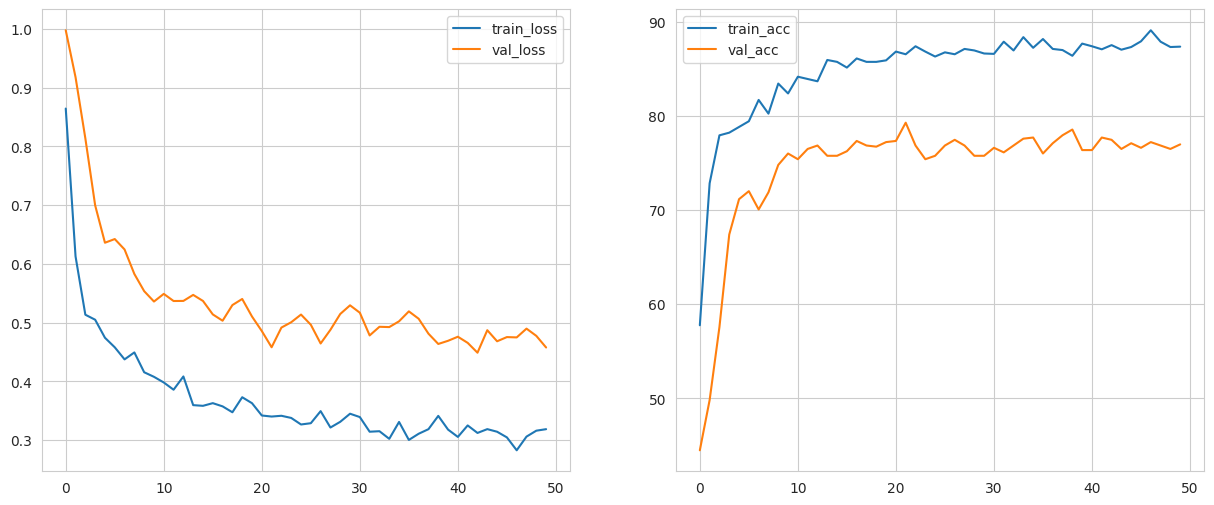

In [1664]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(history[0, :], label="train_loss")
ax1.plot(history[2, :], label="val_loss")
ax1.legend()

ax2.plot(history[1, :], label="train_acc")
ax2.plot(history[3, :], label="val_acc")
ax2.legend()

# Evaluation

In [1665]:
model.eval()
true_preds, num_preds = 0., 0.

test_y_hat = []
test_y = []
with torch.no_grad():
    for data_inputs, data_labels in test_data_loader:
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)


        logits = model(data_inputs)
        predictions, correct = predict_from_logits(logits, data_labels)


        test_y_hat.append(predictions.to("cpu").numpy())
        test_y.append(data_labels.to("cpu").numpy())

        true_preds += correct
        num_preds += data_labels.shape[0]

test_accuracy = (true_preds / num_preds) * 100.0
print(f"Accuracy of the model: {test_accuracy:.2f}%")

Accuracy of the model: 81.20%


In [1666]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


In [1667]:
test_y = np.concatenate(test_y)
test_y_hat = np.concatenate(test_y_hat)

In [1668]:
cm = confusion_matrix(test_y, test_y_hat)

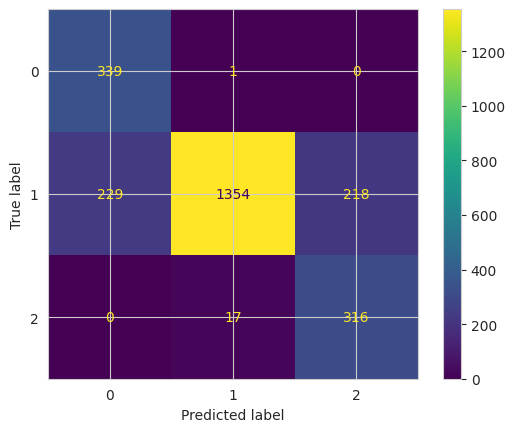

In [1669]:

disp = ConfusionMatrixDisplay(cm, display_labels=[str(x) for x in range(cm.shape[0])])
disp.plot()
plt.show()

In [1670]:
def accuracies_for_classes(cm: np.array):
    accuracies = []
    for class_idx in range(cm.shape[0]):
        acc = (cm[class_idx, class_idx] / np.sum(cm[class_idx, :])) * 100
        accuracies.append(acc)

    return accuracies

In [1671]:
accuracies = accuracies_for_classes(cm)
labels = ["Cheap", "Average", "Expensive"]
for i, acc in enumerate(accuracies):
    print(f"Accuracy for class {labels[i]:<10} ({i}): {acc:.2f} %")
print()
print(f"Test accuracy: {test_accuracy:.2f} %")
print(f"Average accuracy: {sum(accuracies)/3:.2f} %")

Accuracy for class Cheap      (0): 99.71 %
Accuracy for class Average    (1): 75.18 %
Accuracy for class Expensive  (2): 94.89 %

Test accuracy: 81.20 %
Average accuracy: 89.93 %


In [1672]:
# state_dict = model.state_dict()
# torch.save(state_dict, "apartments_89_average_test.tar")